# EE 120 Lab 6: Control

v1 - Spring 2019: Jonathan Lee, Akash Velu, Babak Ayazifar

v2 - Fall 2019: Jonathan Lee, Murat Arcak

## Background

Most interesting systems in the physical world use feedback to regulate or stabilize themselves.
For example, imagine you're building the steering system for a car.
Most modern cars are drive-by-wire, meaning that instead of a direct mechanical link from the steering wheel to the front wheels, there's a computer driving a motor to perform steering.

In an open-loop system, you would simply program the computer to have the wheel angle track the steering wheel and hope that the angles match.
However, you might consider a closed-loop system instead where you use a sensor to measure the actual wheel angle, then drive the motor until it matches the reference angle.

* The controller design is greatly simplified, since the process we are trying to control (called a plant) can be treated as a "black-box".
* Open-loop systems tend to exhibit drift from their desired outputs over time due to modeling imperfections, disturbances, and noise.
  Under a closed-loop system, the input compensates for errors as they occur.
* Closed-loop control can correct for errors at much higher frequency than a human operator can.

### Dependencies

In addition to the `scipy` stack, we'll need the [`python-control`](https://python-control.readthedocs.io/en/0.8.2/) package to visualize root locus.
You can install the package with one of the following commands (depending on whether you use the `pip` Python package manager or Anaconda):
```
$ pip install --user control
$ conda install -c conda-forge control
```

If you're having trouble installing the package, post on Piazza with your OS, Python version, and other debug information, or get help at office hours.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
import control
from matplotlib.animation import FuncAnimation
from __future__ import division, print_function, unicode_literals

if 'ggplot' in plt.style.available:
    plt.style.use('ggplot')
%matplotlib inline

<img src="nt/QQ20220531-205941@2x.png" style="zoom:0.5" />

## Q1: Proportional-Integral-Derivative (PID) Control

![Control Scheme](ctrl-scheme.png)

A block diagram of a general reference tracking scheme we're going to look at is shown above.
- $P(s)$ is <span class="mark">the Laplace transform (LT) of the plant.</span> We assume the plant can be well-modeled as an LTI system (for example, a differential equation).
- $H(s)$ is <span class="mark">the LT of the controller.</span> This is the part we'd like to design.
- $r(t)$ is the desired <span class="mark">reference signal (also known as the "setpoint").</span>
- $y(t)$ is the output signal.
- $e(t) = r(t) - y(t)$ is the error signal.
- $u(t)$ is the control input.

Given a reference signal $r(t)$, we would like $r(t)$ to closely track $y(t)$. That is, ideally, we'd like $e(t) \approx 0$.

We can derive the closed-loop transfer function:

\begin{align}
    Y(s) &= P(s)\,H(s)\left[R(s) - Y(s)\right] \\
    (1 + P(s)\,H(s))\,Y(s) &= P(s)\,H(s)\,R(s) \\
    \frac{Y(s)}{R(s)} &= \frac{P(s)\,H(s)}{1 + P(s)\,H(s)}
\end{align}

We can also derive the LT of the error signal:

\begin{align}
    E(s) &= R(s) - Y(s) \\
        &= R(s) - \frac{Y(s)}{R(s)} R(s) \\
        &= R(s) \left[1 - \frac{P(s)\,H(s)}{1 + P(s)\,H(s)}\right] \\
        &= \frac{R(s)}{1 + P(s)\,H(s)}
\end{align}

<span class="mark">PID is a popular controller used to design $H(s)$.
The idea is that the control input should be a linear combination of the error signal, error derivative, and integrated error:</span>

$$u(t) = K_p e(t) + K_d \frac{\mathrm{d}}{\mathrm{d}t} e(t) + K_i \int_0^t e(\tau)\,\mathrm{d}\tau$$

In some sense, these encode the current, future, and past error, respectively.
$K_p, K_i, K_d \geq 0$ can be tuned to control the relative importance of each term.

### Q1(a): Step Responses

First, we'll look at an example of controlling a simple second-order plant with PID:

$$P(s) = \frac{1}{(s+2)^2}$$

In [3]:
def plot_step_response(ax, sys):
    """ Plot the step response of a given system. """
    t, y = control.step_response(sys)
    ax.plot(t, y)
    ax.plot(t, np.where(t > 0, np.ones(y.shape), np.zeros(y.shape)))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Response')

plant = control.tf([1], [1, 4, 4])   # 分子和分母的系数 1 / (s^2 + 4s + 4)  -> [1], [1, 4, 4]

To complete this question, implement `make_pid_tf` and `make_overall_tf` according to the instructions in the docstring.
You'll want to familiarize yourself with the `control` package documentation:
* [Creating transfer functions](https://python-control.readthedocs.io/en/0.9.2/generated/control.tf.html?highlight=tf) (also, see above for how `plant` is defined)
* [Composing transfer functions](https://python-control.readthedocs.io/en/0.9.2/control.html?highlight=interconnections#system-interconnections)

The polynomials accepted by `control.tf` should be encoded as coefficients of powers of $s$, in decreasing order of degree.
For example:

$$3s^3 + 2s^2 + s \text{ is encoded as } \texttt{[3, 2, 1, 0]}$$

This means you'll need to derive $H(s)$ in a simple rational form.

注意到

$$u(t) = K_p e(t) + K_d \frac{\mathrm{d}}{\mathrm{d}t} e(t) + K_i \int_0^t e(\tau)\,\mathrm{d}\tau$$

$$
    U(s) = K_p E(s) + K_d sE(s) + K_i \frac{1}{s} E(s)
$$

$$
    H(s) := \frac{U(s)}{E(s)} = K_p +K_ds + \frac{K_i}{s}
$$

`control.feedback()` 中 `sys1` 为 $H(s)P(s)$, `sys2` 为 $1$

In [4]:
def make_pid_tf(Kp, Ki, Kd):
    """
    Make the PID controller transfer function H(s) = U(s)/E(s)
    (as defined above) with proportional, integral, and derivative
    coefficients `Kp`, `Ki`, and `Kd`.
    """
    return control.tf([Kd, Kp, Ki], [1, 0]) # TODO: Your code here.

def make_cl_tf(plant_tf, controller_tf):
    """
    Make the closed-loop transfer function Y(s)/R(s) given the
    transfer functions of the controller and plant.
    
    Hint: `control.feedback(sys1, sys2)` represents this system:
    
                 +------+
        ----+--> | sys1 |---+--->
          - ^    +------+   |
            |               |
            |    +------+   |
            +----| sys2 |<--+
                 +------+
    
    If you leave out the `sys2` argument, then the output is simply
    subtracted from the closed-loop input (unit gain feedback).
    """
    return control.feedback(control.series(plant_tf, controller_tf))  # TODO: Your code here.

Now, we'll examine the step response $y(t)$ as we tweak the parameters $K_p, K_i, K_d$.

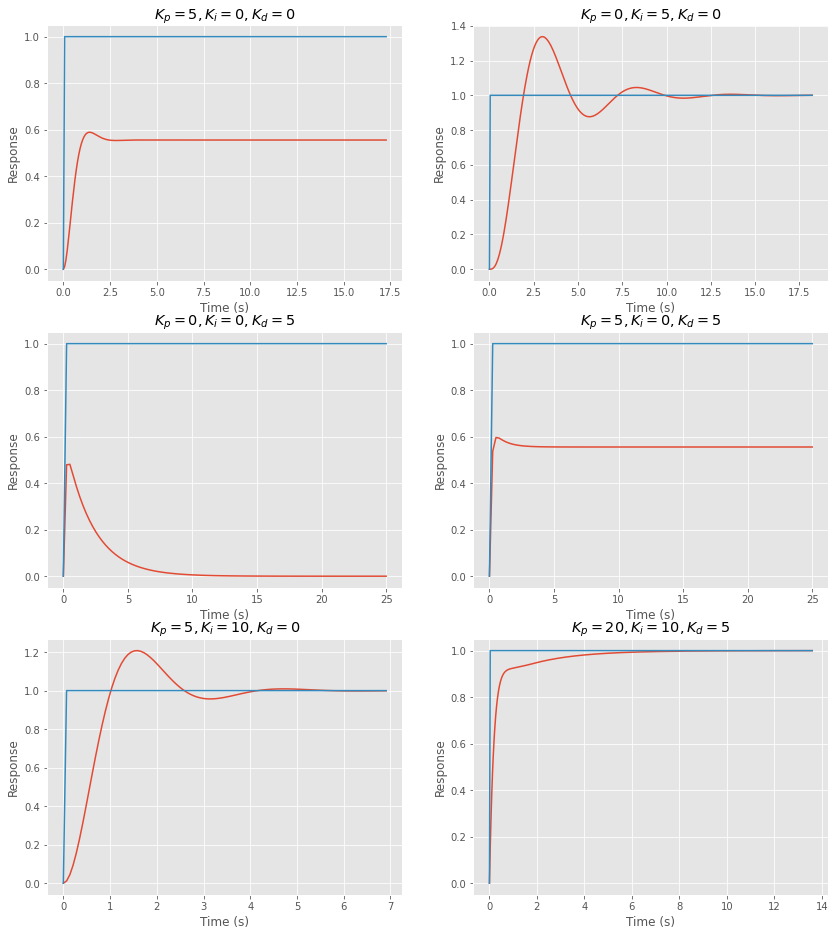

In [11]:
gain_configs = [
#     (0, 0, 0),          # my test
    (5, 0, 0),  # P control (purely proportional)
#     (5, 0, 1),          # my test
    (0, 5, 0),
#     (0, 5, 5),          # my test
    (0, 0, 5),
    (5, 0, 5),  # PD
    (5, 10, 0),  # PI
#     (5, 0, 0),         # my test
    (20, 10, 5),  # PID
]
rows, columns = 3, 2

figure, axes = plt.subplots(rows, columns, figsize=(14, 16))
for i, gains in enumerate(gain_configs):
    controller = make_pid_tf(*gains)
    cl_tf = make_cl_tf(plant, controller)
    row, column = i//columns, i%columns
    ax = axes[row, column]
    plot_step_response(ax, cl_tf)
    ax.set_title('$K_p = {}, K_i = {}, K_d = {}$'.format(*gains))

**Qualitatively, what effect does the derivative term seem to have? Compare the step responses of $K_d = 0$ against $K_d > 0$.**

<span style="color: #f00">
    TODO: Make the oscillation smaller and the response slower?
</span>

**What effect does the integral term seem to have? Compare the step responses of $K_i = 0$ against $K_i > 0$.**

<span style="color: #f00">
    TODO: The integral term allows the step resopnses to converges to 1.
</span>

Feel free to continue playing around with the coefficients and seeing how they affect the step response.
As you might notice, some step responses might not converge to the reference input at all.
This is due to steady-state error, which is simply a consequence of the final value theorem.
In the case of the P controller,（仅有 $K_p$ 项，无 $K_i, K_d$）

\begin{align}
\lim_{t \to \infty} e(t) &= \lim_{s \to 0^+} sE(s) \\
    &= \lim_{s \to 0^+} s \frac{R(s)}{1 + P(s)\,H(s)} \\
    &= \lim_{s \to 0^+} \frac{1}{1 + K_p H(s)} \\
    &= \lim_{s \to 0^+} \frac{(s+2)^2}{(s+2)^2 + K_p} \\
    &= \frac{4}{4 + K_p} \neq 0
\end{align}

### Q1(b): Robust Differentiation

In practice, adding <span class="mark">a pure differentiation term to the PID expression is generally not a good idea.
As you saw in homework 3, differentiation can amplify the high-frequency components in noise and drown out the differentiated signal.</span>
Here, we'll take the control scheme in 1(a) and introduce some noise to the feedback path (see note 20), which will be subtracted from the reference signal.

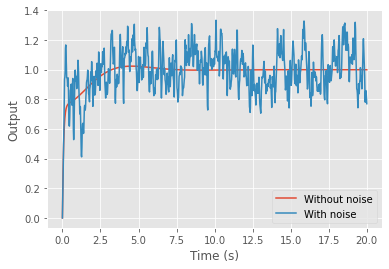

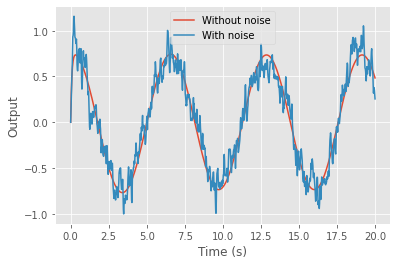

In [12]:
controller = make_pid_tf(10, 10, 10)
cl_sys = make_cl_tf(plant, controller).returnScipySignalLTI()[0][0]

def plot_response_with_noise(cl_sys, t_in, ref, noise):
    """
    Plot the step response of a system with and without noise,
    superimposed on the same plot.
    """
    plt.plot(*cl_sys.output(ref, t_in)[:2], label='Without noise')
    plt.plot(*cl_sys.output(ref + noise, t_in)[:2], label='With noise')
    plt.xlabel('Time (s)')
    plt.ylabel('Output')
    plt.legend()

t_in = np.linspace(0, 20, 1000)
step, cos = np.ones(t_in.shape), np.cos(t_in)
noise = np.random.normal(0, 0.5, t_in.shape)
plot_response_with_noise(cl_sys, t_in, step, noise)
plt.figure()
plot_response_with_noise(cl_sys, t_in, cos, noise)

<span class="mark">One way to deal with this is to apply a low-pass filter before differentiating.</span>
For example, we can replace the term $K_d s$ with $\frac{K_d s}{s/\omega_c + 1}$, where $\omega_c$ is some cutoff frequency.
We can interpret the factor $(s/\omega_c + 1)^{-1}$ as a first-order low-pass filter connected in series with the regular derivative term.
Typically, we assume the frequencies in the reference/output will be much lower than the frequencies that comprise the noise.

(0.0, 100.0)

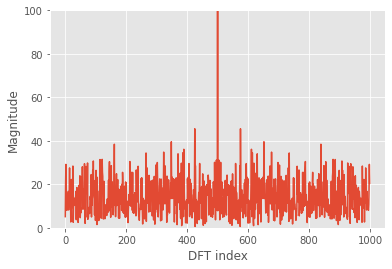

In [13]:
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(step + noise))))
plt.xlabel('DFT index')
plt.ylabel('Magnitude')
plt.ylim(0, 100)  # Ensure the entire spectrum is visible.

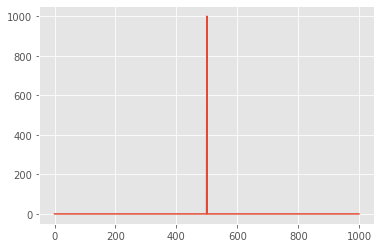

In [16]:
plt.figure()
plt.plot(np.fft.fftshift(np.fft.fft(step)))
plt.show()

Here, we've plotted the spectrum of the reference input with the noise.
With `np.fft.fftshift`, the lowest-frequency component is now at the middle index.

**Explain the spike you see above.**

<span style="color: #f00">
    TODO: It is the DFT of the unit step signal (see the cell below) $U[k]$. $U[k] \neq 0$ only if $k = 0$.
</span>

Your task here is to implement `make_filtered_pid_tf`, which is exactly like `make_pid_tf`, but uses the filtered derivative with a value of $\omega_c$ you should determine empirically.
Remember that you can make $\omega_c$ quite low because we're trying to eliminate almost everything you see in the spectrum of the noisy reference signal.
Again, you will need to derive a simple rational form of $H(s)$ that can be plugged into `control.tf`.

If you've implemented the filter correctly, the response should be cleaned up considerably with some low-frequency sinusoids remaining.
Your noiseless step response might have changed slightly as well.

$$
        H(s) = K_p +K_ds + \frac{K_i}{s} 
$$
$$
    \to H(s) =  K_p + \frac{K_ds}{s / \omega_c + 1} + \frac{K_i}{s} = \frac{(\frac{1}{\omega_c}K_p + K_d)s^2 + (\frac{1}{\omega_c}K_i + K_p)s + K_i}{\frac{1}{\omega_c} s^2 + s}
$$

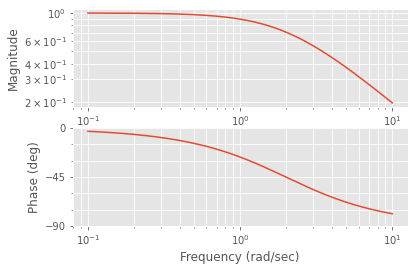

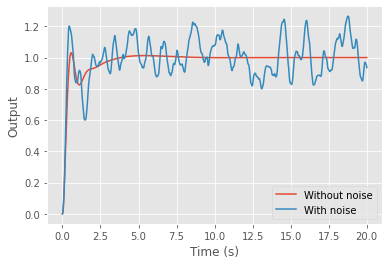

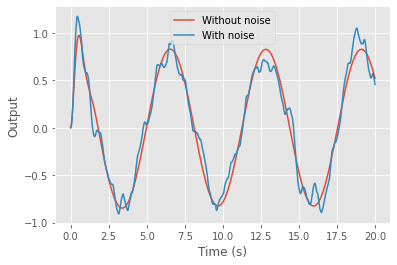

In [24]:
wc = 2  # TODO: determine a suitable \omega_c

def make_filtered_pid_tf(Kp, Ki, Kd):
    """
    Make the PID controller transfer function H(s) with a first-order
    lowpass filter on the derivative term.
    """
    return control.tf([Kp/wc + Kd, Ki/wc + Kp, Ki], [1/wc, 1, 0]) # TODO

control.bode_plot(control.tf([1], [1/wc, 1]))
plt.figure()
cl_sys = make_cl_tf(plant, make_filtered_pid_tf(10, 10, 10)).returnScipySignalLTI()[0][0]
plot_response_with_noise(cl_sys, t_in, step, noise)
plt.figure()
plot_response_with_noise(cl_sys, t_in, cos, noise)

### Q1(c): Stabilizing an Unstable System

Finally, we'll look at using feedback to stabilize an unstable plant:

$$P(s) = \frac{1}{(s+2)(s-2)}$$

Assuming the system is causal, the RoC is $\text{Re}(s) > 2$, which does not include the $j\omega$-axis.
One naive solution might involve not using feedback at all and cascading the plant with the transfer function $H(s) = s-2$ to cancel the unstable pole.
However, we typically don't know the _exact_ placement of the unstable pole, so this method will fail to remove the instability.

The step response of the plant is shown below.
As you can see, the pole at $s = 2$ adds an exponential that grows without bound.

Text(0, 0.5, 'Plant Step Response')

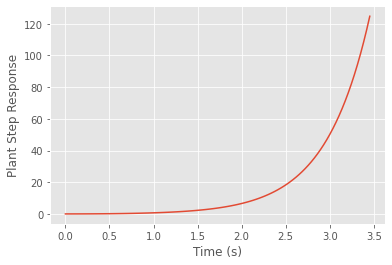

In [25]:
plant = control.tf([1], [1, 0, -4])
plt.plot(*control.step_response(plant)[:2])
plt.xlabel('Time (s)')
plt.ylabel('Plant Step Response')

<span class="mark">If we plot the [root locus](https://python-control.readthedocs.io/en/0.8.2/generated/control.root_locus.html#control.root_locus) of the plant, we'll see how the roots of $1 + K_p P(s) = 0$ move as we tweak $K_p$</span>.

**Can we stabilize the system with constant gain feedback? Why or why not?**

<span style="color: #f00">
    TODO: your answer here.
</span>

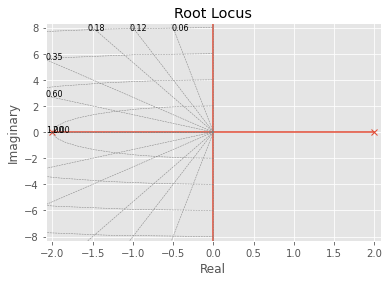

In [26]:
_ = control.root_locus(plant)

We'll need to try something more sophisticated that vanilla PID to move all the closed-loop poles into the left-half plane.
Let's try a lead controller (as shown in note 19):

$$H(s) = K \frac{s-\beta}{s-\alpha}$$

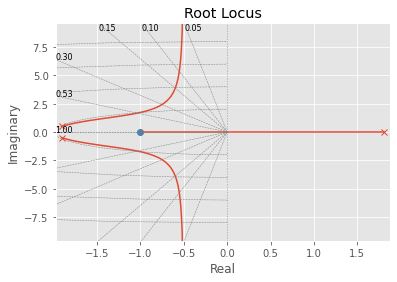

In [27]:
alpha, beta = -2, -1
controller = control.tf([1, -beta], [1, -alpha])
r_locs, gains = control.root_locus(make_cl_tf(plant, controller))

In [38]:
# np.info(r_locs)
np.info(gains)
r_locs[:, 0]
r_locs[:, 1]
r_locs[:, 2]
gains

class:  ndarray
shape:  (103,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x7f8b63ae7050
byteorder:  little
byteswap:  False
type: float64


array([0.00000000e+00, 4.55982295e-01, 9.11964591e-01, 1.36794689e+00,
       1.82392918e+00, 2.27991148e+00, 2.73589377e+00, 3.19187607e+00,
       3.64785836e+00, 4.10384066e+00, 4.55982295e+00, 5.01580525e+00,
       5.47178755e+00, 5.76009066e+00, 6.04839377e+00, 6.33669689e+00,
       6.62500000e+00, 6.62500000e+00, 7.29571673e+00, 7.75169902e+00,
       8.20768132e+00, 8.66366361e+00, 9.11964591e+00, 9.57562820e+00,
       1.00316105e+01, 1.04875928e+01, 1.09435751e+01, 1.13995574e+01,
       1.18555397e+01, 1.23115220e+01, 1.27675043e+01, 1.32234866e+01,
       1.36794689e+01, 1.41354512e+01, 1.45914335e+01, 1.50474158e+01,
       1.55033980e+01, 1.59593803e+01, 1.64153626e+01, 1.68713449e+01,
       1.73273272e+01, 1.77833095e+01, 1.82392918e+01, 1.86952741e+01,
       1.91512564e+01, 1.96072387e+01, 2.00632210e+01, 2.05192033e+01,
       2.09751856e+01, 2.14311679e+01, 2.18871502e+01, 2.23431325e+01,
       2.27991148e+01, 2.32550971e+01, 2.37110794e+01, 2.41670617e+01,
      

Your task is to search `r_locs` and `gains` for a suitable gain that will stabilize the system.
To remind you what `control.root_locus` returns, `r_locs` is a 2D array whose rows are pole locations (since there are three closed-loop poles, every row of `r_locs` is three entries wide).
`gains` is a 1D array of candidate values of $K$ that have been sampled by the `control` package.
The $i^\text{th}$ gain in `gains` corresponds to the $i^\text{th}$ row of closed-loop poles.

Since the goal here is just to stabilize the system, any $K$ that shows the closed-loop system has a stable step response will suffice.
In a real system, we might care about rise time, percent overshoot, and other quantities that would impose constraints on pole placement.
Note that although some rows of `r_locs` might nominally have all strictly negative parts, the step response might still be unstable due to numerical imprecision.
It's safer to pick a larger value of $K$ for which all the poles will be further away from the $j\omega$-axis in the left-half plane.

10.487592795525746


Text(0, 0.5, 'Plant Step Response')

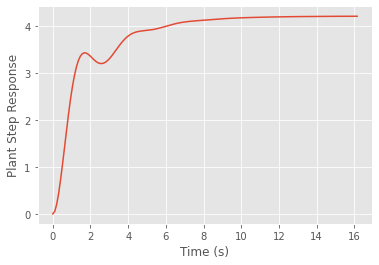

In [43]:
# TODO: your code here.
stable_gain = None
for i in np.arange(gains.size):
    if np.all(r_locs[i, :] < -.5):
        stable_gain = gains[i]
        break
print(stable_gain)

stablized_sys = make_cl_tf(plant, stable_gain*controller)
plt.plot(*control.step_response(stablized_sys)[:2])
plt.xlabel('Time (s)')
plt.ylabel('Plant Step Response')

## Q2: Inverted Pendulum (Optional)

Now, we'll apply PID to solve a classic problem in control theory: balancing an inverted pendulum mounted on a cart.
Unfortunately, we don't have the hardware to show your control scheme in action, but here's [a clip](https://youtu.be/nqOU2CGeAvk?t=455) of a SpaceX landing performing similar stabilization.

<img src="cart.png" alt="Cart-Pole System" width="50%" />

The setup is shown in the schematic above.
- The mass of the cart and pole are denoted $M$ and $m$, respectively.
- The length of the pole is $\ell$.
- The input to the system is a continuous force $F$. For simplicitly, we won't assume any constraints on $F$.
- The output of the system is the angle $\theta$ the pole makes with the vertical, as depicted by the dashed line in the diagram above.
- $x$ is the cart's position relative to some fixed origin.
- The pole's angle cannot be controlled directly.
  The only control we have is force, which is related to $x$ and $\theta$ by differential equations.

As it turns out, the relationship between $F$ and $\theta$ is nonlinear.
However, for small $\theta$, the system is well-approximated as an LTI system, meaning the plant has a transfer function and can be controlled with PID.

In [51]:
# Feel free to ignore this block.

class CartPoleSimulation:
    """
    Simulate an inverted pole on a cart.

    The state of the system is a four-entry vector containing:
      * x: Cart's position.
      * x_dot: Cart's velocity.
      * theta: Pole's angular position.
      * theta_dot: Pole's angular velocity.
    """
    cart_mass, pole_mass, pole_length, gravity = 1, 0.1, 1, 9.8
    # Just for visualization. These have no effect on the dynamics.
    cart_width, cart_height = 0.5, 0.25

    def __init__(self, initial_state=None, dt=0.02):
        if initial_state is None:
            initial_state = np.zeros(4)
        self.initial_state = self.state = initial_state
        self.dt = dt
    
    def reset(self):
        self.state = self.initial_state

    def step(self, force):
        """
        Simulate the evolution of the system over a small time step.

        Arguments:
            force (float): The force applied to the cart.

        Returns:
            The state vector after the time step is over.
            The internal state of the simulation is also mutated.
        """
        # These nonlinear dynamics represent the system in full fidelity.
        M, m, l = self.cart_mass, self.pole_mass, self.pole_length
        x, x_dot, theta, theta_dot = self.state
        A = np.array([
            [l**2*m, -l*m*np.cos(theta)],
            [-l*m*np.cos(theta), M + m],
        ])
        velocities = np.linalg.inv(A).dot(np.array([
            l*m*self.gravity*np.sin(theta),
            -l*m*theta_dot*np.sin(theta) + force,
        ]).reshape(2, 1))
        theta_ddot, x_ddot = velocities[0, 0], velocities[1, 0]
        self.state = np.array([
            x + x_dot*self.dt,
            x_dot + x_ddot*self.dt,
            theta + theta_dot*self.dt,
            theta_dot + theta_ddot*self.dt,
        ])
        return self.state

    def simulate(self, control_input, disturbance=None, steps=500):
        disturbance = disturbance or (lambda _: 0)
        trajectory = np.empty((steps, self.state.shape[0] + 2), dtype=np.float64)
        self.reset()
        for t in range(steps):
            u = control_input(self.state)
            w = disturbance(self.state)
            trajectory[t, :4] = self.step(u + w)
            trajectory[t, 4], trajectory[t, 5] = u, w
        return trajectory

    def animate(self, trajectory):
        figure, ax = plt.subplots(figsize=(16, 4))
        pole = plt.Line2D((0, 0), (0, 0), lw=2)
        cart = plt.Rectangle((0, -self.cart_height), 
                             self.cart_width, self.cart_height)
        control = plt.Line2D((0, 0), (0, 0), lw=2, color='#4dd056')
        disturbance = plt.Line2D((0, 0), (0, 0), lw=2, color='#e7724d')
        ax.add_line(pole)
        ax.add_line(control)
        ax.add_line(disturbance)
        ax.add_patch(cart)
        ax.axis('equal')
        ax.set_xlim(-10, 10)
        ax.set_ylim(-1, 2)

        def step_animation(state):
            x, _, theta, _, u, w = state
            pole.set_data([x, x - np.sin(theta)],
                          [0, np.cos(theta)])
            cart.set_x(x - self.cart_width/2)
            control.set_data([x, x + u], [-self.cart_height/2 + 0.05]*2)
            disturbance.set_data([x, x + w], [-self.cart_height/2 - 0.05]*2)
            return (pole, cart)

        return FuncAnimation(figure, step_animation, states, interval=1000*self.dt, blit=True)
    
class Disturbance:
    def __init__(self):
        self.counter, self.force = 0, 0

    def push(self, state):
        if self.counter == 0:
            self.counter = np.random.randint(10, 20)
            # Alternate between adding and not adding force.
            if abs(self.force) < 1e-6:
                self.force = np.random.uniform(-0.3, 0.3)
            else:
                self.force = 0
        self.counter -= 1
        return self.force

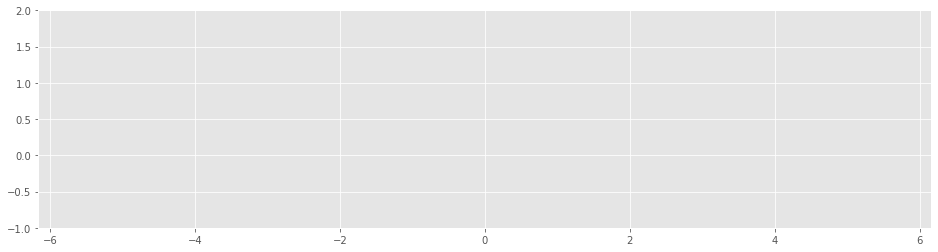

In [52]:
sim = CartPoleSimulation()
states = sim.simulate(lambda _: 0.5)
HTML(sim.animate(states).to_jshtml())

You should see an animation of the cart-pole system above.
The animation might take a minute to compute.
* The blue box and red line represent the cart and pole, respectively.
* The green line indicates the force applied by the controller.
* An orange line would indicate a piecewise constant disturbance, which is another force that is added to the control input before it is fed into the plant.

As shown, the controller just applies a constant force of +0.5, which causes the cart to accelerate rightwards and the pole to fall over.
Your task will be to implement a controller to keep the pole upright even when disturbances are applied.
In particular, the main challenge will involve tuning the PID parameters for $\theta$ appropriately (you can ignore $x$).
It's possible to get the pole to stay upright with just PD control.
Remember that the reference (desired) signal for $\theta$ is identically zero, because that's when the pole is in the upright position.

The derivatives $\dot{x}$ and $\dot{\theta}$ are already automatically computed for you on every time step, and stacked into a state vector $\texttt{state} = (x, \dot{x}, \theta, \dot{\theta})$ that's passed into the `control_input` method of `Controller`.

In [55]:
class Controller:
    def __init__(self, gains, dt=0.02):
        self.gains, self.dt = np.array(gains), dt
        self.Kp, self.Ki, self.Kd = self.gains    #
        # In case you want to use integral control, you can
        # approximate the integrated error by adding
        # error*dt to the counter at every time step.
        #
        # However, empirically, adding an I term doesn't
        # seem to work that well because \theta is highly
        # sensitive to gravity.
        self.x_error = 0
        self.theta_error = 0

    def control_input(self, state):
        """
        Computes the force that should be applied to the cart.
        Called on each time step.
        
        Arguments:
            state (numpy.ndarray): An array of shape (4,) containing
                x, x_dot, theta, theta_dot at the current timestep.
        
        Returns:
            u(t) = F(t)
        """
        theta_dot = state[2]
        theta = state[3]
        return -(self.Kp * theta + self.Kd * theta_dot)  # TODO: your code here.

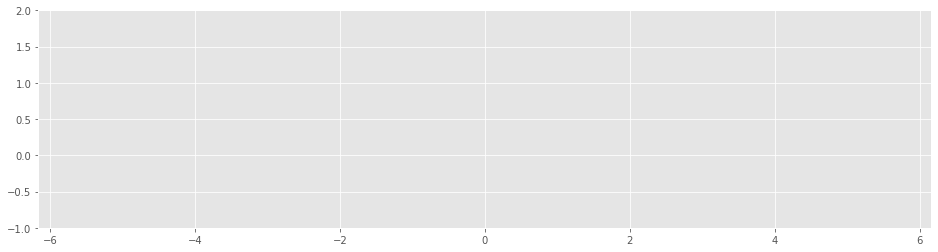

In [56]:
sim.reset()
controller = Controller([10, 5, 10])  # TODO: your theta PID parameters here.
disturbance = Disturbance()
states = sim.simulate(controller.control_input, disturbance.push)
HTML(sim.animate(states).to_jshtml())

## Conclusion

* Here, we've presented control for simple single-input single-output (SISO) systems.
  You can imagine extending this framework to multiple-input multiple-output (MIMO) systems to control multiple state variables at once (for example, controlling both $x$ and $\theta$ in the demo above).
* Tuning PID will often depend on the kind of transient and steady-state behavior you're trying to achieve (e.g. overshoot, rise time, etc).
  EE 128 goes much deeper into how to perform this design, and how the frequency-based techniques you've learned in 120 relate to state-space-based techniques.
* There are many extensions we can consider:
    * Saturation: There are limits to what controls can be applied. For example, an op-amp that's applying a gain will saturate outside of its voltage rails. [Here](http://www.cds.caltech.edu/~murray/books/AM08/pdf/fbs-pid_01Jan19.pdf) are some ways to deal with saturation and integral windup.
    * Sometimes, the control signal generated might involve switching an actuator on and off at a very high frequency, which might be undesirable because it can wear out a physical system.
      Not surprisingly, the solution might involve lowpass-filtering the control signal.
    * A control signal might incur considerable cost to apply, so we might want to model finding the control as an optimization problem.
      Linear Quadratic Regulator (LQR) is one popular technique for operating a system optimally whose cost is quadratic in the states and inputs (some [notes](http://inst.eecs.berkeley.edu/~ee221a/fa19/lectures/Lecture11b_Somil.pdf) on the discrete-time case).
      It turns out LQR is easy to solve with dynamic programming.